In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

import nltk

In [4]:
df = pd.read_csv('../data/subreddit_data.csv')
df.head(3)

,subreddit,title,selftext,score,num_comments,created_utc,total_text,title_length,selftext_length,title_word_count,selftext_word_count
0,0,Careers with a BS in Mechanical Engineering,1,60,210,1638995117,careers with a bs in mechanical engineering hi...,43,726,7,132
1,0,Am I really an engineer?,1,19,59,1638988318,am i really an engineer? let me first explain ...,24,2129,5,362
2,0,How do lighthouses withstand being constantly ...,1,17,20,1638986902,how do lighthouses withstand being constantly ...,85,411,13,46


In [5]:
#Baseline which will obviously be 50% on the dot
df['subreddit'].value_counts(normalize = True)

0    0.5
1    0.5
Name: subreddit, dtype: float64

In [6]:
features = ['total_text']#, 'selftext'] #,'title_length','selftext_length', 'title_word_count', 'selftext_word_count' ]
X = df['total_text']
y = df['subreddit']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, stratify=y)

In [8]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    split_text = text.split(' ')
    return [lemmatizer.lemmatize(word) for word in split_text]

In [9]:
def stem_text(text):
    p_stemmer = PorterStemmer()
    split_text = text.split(' ')
    return [p_stemmer.stem(word) for word in split_text]

### Logistic Regression Pipeline

In [9]:
pipe_lr = Pipeline([
    ('vect', CountVectorizer()),
    ('lr', LogisticRegression(random_state=13))
])

In [10]:
params_lr = {
    #best
    'lr__max_iter': [500],
    'vect__binary': [True],
    #'vect__max_df': [1],
    #'vect__min_df': [0.25],
    'vect__stop_words': [None],
    'vect__tokenizer': [lemmatize_text]
    
     #tests
     #'vect__stop_words': [None, 'english'],
     #'vect__min_df': range(1, 10, 2),
     #'vect__max_df': [1.0, .75, .5, .25],
     #'vect__tokenizer': [stem_text, lemmatize_text, None],
     #'vect__binary': [True, False],
     #'lr__penalty': [ 'l2', 'elasticnet', None],
     #'lr__max_iter' : [500],

}

gs_lr = GridSearchCV(pipe_lr,
                  param_grid=params_lr)
gs_lr.fit(X_train, y_train)
print(gs_lr.best_score_) # <- cross val score FTW
gs_lr.best_params_

0.9820051413881747


{'lr__max_iter': 500,
 'vect__binary': True,
 'vect__stop_words': None,
 'vect__tokenizer': <function __main__.lemmatize_text(text)>}

### KNN Pipeline

In [11]:
pipe_knn = Pipeline([
    ('vect', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [12]:
params_knn = {
     'vect__stop_words': [None, 'english'],
     'vect__min_df': range(1, 10, 2),
     'vect__max_df': [1.0, .75, .5, .25],
     #'vect__tokenizer': [stem_text, lemmatize_text, None]
     'vect__binary': [True, False],
     'knn__n_neighbors': [5,7,10],
     'knn__weights' : ['uniform','distance'],
    
}

gs_knn = GridSearchCV(pipe_knn,
                  param_grid=params_knn)
gs_knn.fit(X_train, y_train)
print(gs_knn.best_score_) # <- cross val score FTW
gs_knn.best_params_

0.7969151670951157


{'knn__n_neighbors': 5,
 'knn__weights': 'uniform',
 'vect__binary': False,
 'vect__max_df': 0.5,
 'vect__min_df': 5,
 'vect__stop_words': None}

### RandomForest Pipeline

In [14]:
pipe_rf = Pipeline([
    ('vect', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state=13))
])

In [15]:
params_rf = {
    #best
    'vect__binary': [True],
    'vect__max_df': [0.5],
    'vect__min_df': [9],
    'vect__stop_words':[ None]
    
    #tests
    #'vect__stop_words': [None, 'english'],
    #'vect__min_df': range(1, 10, 2),
    #'vect__max_df': [1.0, .75, .5, .25],
    #'vect__tokenizer': [stem_text, lemmatize_text, None]
    #'vect__binary': [True, False],
    #'rf__n_estimators': [75, 100, 125],
    #'rf__max_depth': [None, 3, 4, 5],
    #'rf__max_features': ['auto', 3, 4, 5]
}
gs_rf = GridSearchCV(pipe_rf, param_grid=params_rf)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
gs_rf.best_params_

0.9403598971722366


{'vect__binary': True,
 'vect__max_df': 0.5,
 'vect__min_df': 9,
 'vect__stop_words': None}

### AdaBoost Model

In [16]:
pipe_aboost = Pipeline([
    ('vect', CountVectorizer()),
    ('aboost', AdaBoostClassifier(random_state=13))
])

In [17]:
params_aboost = {
    #best
    'vect__binary': [True],
    'vect__max_df': [0.5],
    'vect__min_df': [1],
    'vect__stop_words': [None]
    
    #tests
    #'vect__stop_words': [None, 'english'],
    #'vect__mGradientBoostingClassifierf': range(1, 10, 2),
    #'vect__max_df': [1.0, .75, .5, .25],
    #'vect__tokenizer': [stem_text, lemmatize_text, None]
    #'vect__binary': [True, False]
    #'aboost__n_estimators': [25,50, 75, 100,125]
}
gs_aboost = GridSearchCV(pipe_aboost, param_grid=params_aboost)
gs_aboost.fit(X_train, y_train)
print(gs_aboost.best_score_)
gs_aboost.best_params_

0.9367609254498716


{'vect__binary': True,
 'vect__max_df': 0.5,
 'vect__min_df': 1,
 'vect__stop_words': None}

### Gradient Boost Model

In [10]:
pipe_gboost = Pipeline([
    ('vect', CountVectorizer()),
    ('gboost', GradientBoostingClassifier(random_state=13))
])

In [11]:
params_gboost = {
    #best
    'vect__binary': [True],
    'vect__max_df': [0.5],
    'vect__min_df':[ 12, 13, 14],
    'vect__stop_words': [None],
    'vect__tokenizer': [stem_text, lemmatize_text, None],
    'gboost__n_estimators': [200, 250, 275]
    
    #tests
    #'vect__stop_words': [None, 'english'],
    #'vect__min_df': range(1, 10, 2),
    #'vect__max_df': [1.0, .75, .5, .25],
    #'vect__tokenizer': [stem_text, lemmatize_text, None]
    #'vect__binary': [True, False],
    #'gboost__n_estimators': [25,50, 75, 100,125]
}
gs_gboost = GridSearchCV(pipe_gboost, param_grid=params_gboost)
gs_gboost.fit(X_train, y_train)
print(gs_gboost.best_score_)
gs_gboost.best_params_

0.9820051413881747


{'gboost__n_estimators': 275,
 'vect__binary': True,
 'vect__max_df': 0.5,
 'vect__min_df': 14,
 'vect__stop_words': None,
 'vect__tokenizer': <function __main__.stem_text(text)>}

### Results & Metrics

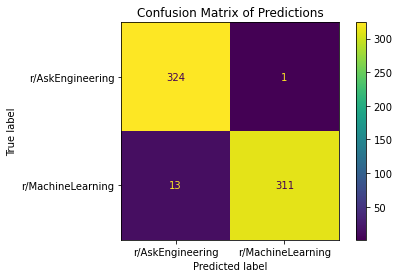

In [25]:
plot_confusion_matrix(gs_gboost, X_test, y_test, display_labels=['r/AskEngineering', 'r/MachineLearning']);
# Only 14 predicted incorrectly, looks like the model falsely predicts Machine Learning posts much more often 
plt.title('Confusion Matrix of Predictions')
plt.savefig('../visualizations/matrix.png', dpi = 200, bbox_inches = 'tight')

In [13]:
pred = gs_gboost.predict(X_test)

X_test[y_test != pred]
# The few that got away

1841    t-net: parametrizing fully convolutional nets ...
1658    bert's success in some benchmarks tests may be...
2012    how to identify state-of-the-art results when ...
1652    [project] tetris-ai - a deep reinforcement lea...
1603    [news] megatron-lm: nvidia trains 8.3b gpt-2 u...
1408    what is the best way to learn about reinforcem...
2046                [r][uc berkeley] everybody dance now 
1516    [news] tensorflow 2.0 is out! the day has fina...
1359    [r][p] talking head anime from a single image ...
75      things you wish you had learned during univers...
2078    [n]: tensorflow 1.10 released biggest changes ...
1362    [d]: what is the future for designing vision m...
1758    [news] sam altman on openai's business model h...
1348    how to control emotions when doing research "[...
Name: total_text, dtype: object

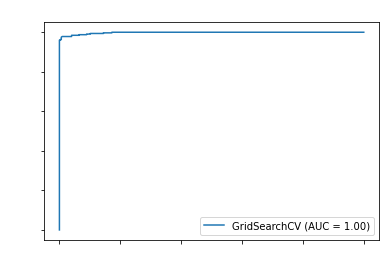

In [23]:
plot_roc_curve(gs_gboost, X_test, y_test);
plt.title('ROC Curve', color ='white')
plt.xticks(color ='white')
plt.yticks(color ='white')
plt.xlabel('False Positive Rate', color ='white')
plt.ylabel('True Positive Rate',color ='white')
plt.savefig('../visualizations/roc.png', dpi = 200, bbox_inches = 'tight')